In [37]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import plot_partial_dependence

plt.style.use("dark_background")

### Data import

In [38]:
PATH = 'C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_engineered.csv'
data = pd.read_csv(PATH, index_col=0)
data['zipTier'] = data['zipTier'].astype('str')

X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Potential dimensionality reduction?
PCA analysis shows that the linear model requires essentially all of the features to account for variance in the data. 

In [39]:
cat_col = ['Private Pool']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age', 'zipTier']
num_pipeline = Pipeline([
                ('std_scaler', StandardScaler())
               ])
X_train_nums = num_pipeline.fit_transform(X_train[num_col])

pca = PCA(n_components=7)
pca.fit(X_train_nums)

PCA(n_components=7)

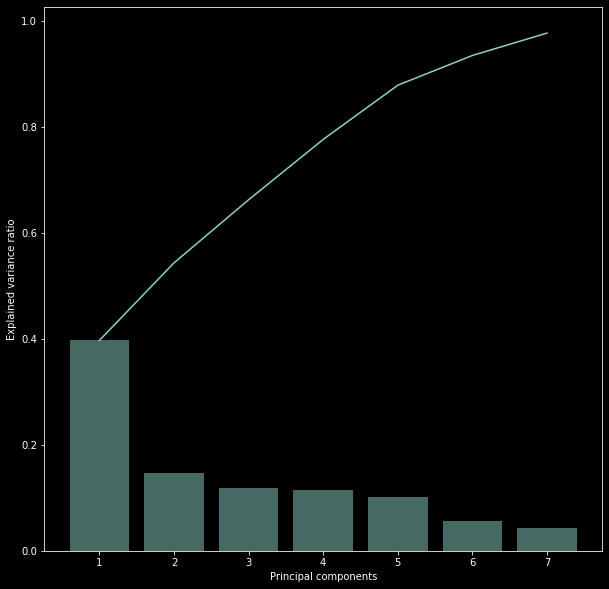

In [40]:
plt.bar(range(1, 8), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.plot(range(1, 8), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

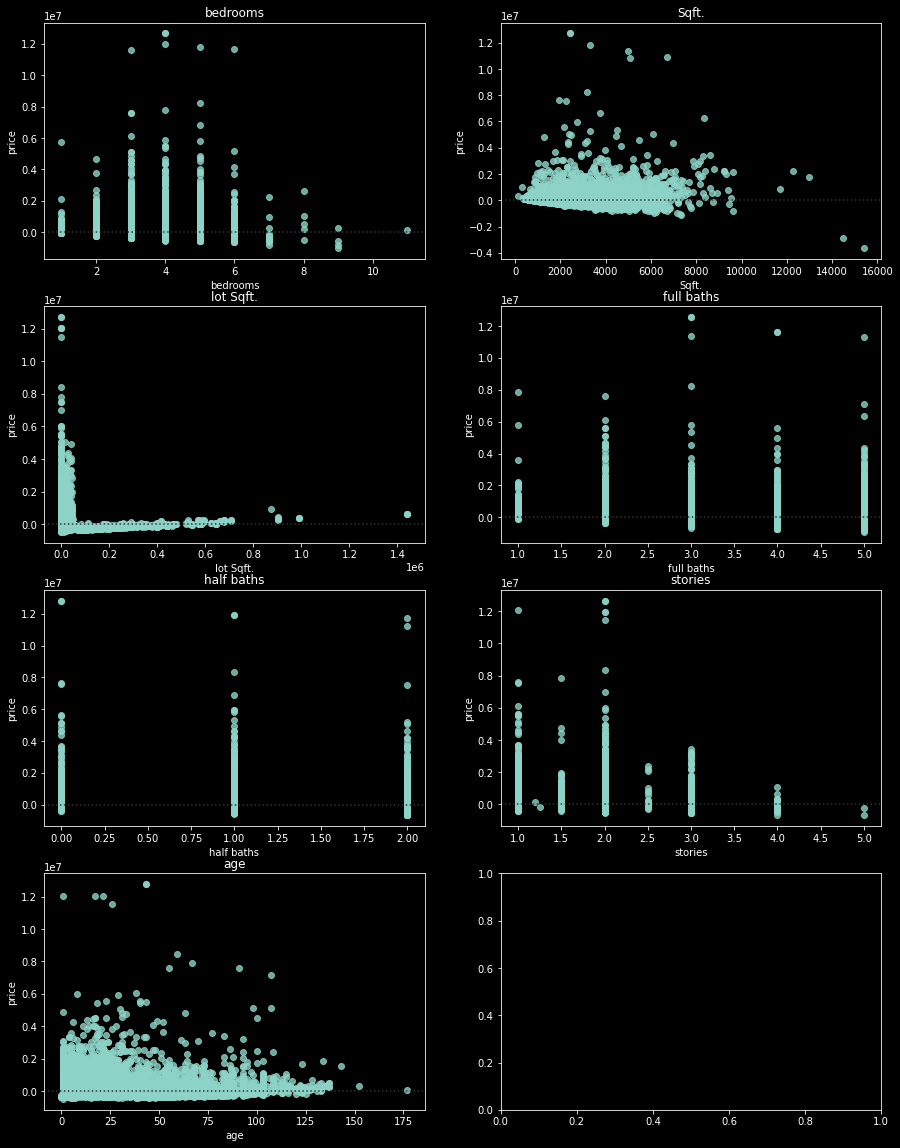

In [59]:

lm = LinearRegression()
lm.fit(X_train_nums, y_train)
features = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']
PartialDependenceDisplay.from_estimator(lm, X_train_nums, features=features, feature_names=features, kind='both', subsample=50)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [42]:

def prepareXData(x_data, cat_cols, num_cols, dropFirst=False):
    """
    Accepts: training data and whether or not to drop the first category in OHE
    Returns: prepared data
    """
    num_pipeline = Pipeline([
            ('std_scaler', StandardScaler())
        ])
    cat_pipeline = Pipeline([
        ('OHE_drop_first', OneHotEncoder())
    ])
    cat_pipe_drop_first = Pipeline([
        ('OHE_drop_first', OneHotEncoder(drop='first'))
    ])

    full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_cols),
            ("cat", cat_pipe_drop_first if dropFirst else cat_pipeline, cat_cols),
        ])
    return full_pipeline

In [43]:
cat_cols = ['zipTier', 'Private Pool']
num_cols = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']

l1_pipeline = prepareXData(X_train, dropFirst=True, cat_cols=cat_cols, num_cols=num_cols)
l2_pipeline = prepareXData(X_train, dropFirst=False, cat_cols=cat_cols, num_cols=num_cols)

X_train_prep, X_test_prep = l1_pipeline.fit_transform(X_train), l1_pipeline.transform(X_test)
X_train_prep_dropfirst, X_test_prep_droppfirst = l2_pipeline.fit_transform(X_train), l2_pipeline.transform(X_test)

In [44]:
def evalModel(X, y, model, folds):
    model.fit(X, y)
    score = model.score(X, y)
    scores = cross_val_score(model, X, y, cv=folds)
    mae = mean_squared_error(y, model.predict(X))
    #print(model.score(X, y))
    print(f'Cross validation scores: {scores}')
    print(f'R^2 score:               {score}')
    print(f'MAE:                     {mae}')

In [45]:
lm = LinearRegression()
evalModel(X_train_prep, y_train, lm, 5)

Cross validation scores: [0.38943904 0.39953789 0.45289553 0.51323161 0.49590446]
R^2 score:               0.4462994990354544
MAE:                     94736563401.82652


In [46]:
rr = Ridge(alpha=1, fit_intercept=False, solver='auto')
evalModel(X_train_prep_dropfirst, y_train, rr, 5)

Cross validation scores: [0.38947022 0.39950724 0.4528884  0.51326005 0.49588416]
R^2 score:               0.4462986851771903
MAE:                     94736702650.63506


In [47]:
lasso = Lasso(alpha=75.0, max_iter=3000, selection='random')
evalModel(X_train_prep_dropfirst, y_train, lasso, 5)

Cross validation scores: [0.38951876 0.39946127 0.45286604 0.51332228 0.49586953]
R^2 score:               0.4462796417995225
MAE:                     94739960917.78972


In [48]:
# parameters = {"n_estimators":(100, 500, 1000),
#               "max_depth":(5, 10, 20),
#               "min_samples_leaf":(5, 7, 10),
#               "max_features":('sqrt', 'log2', None)}
              
# forest = RandomForestRegressor(bootstrap=True, n_jobs=3)
# gs = GridSearchCV(forest, parameters)
# gs.fit(X_train, y_train)

# gs.best_params_
# output:
# {'max_depth': 20,
#  'max_features': 'log2',
#  'min_samples_leaf': 5,
#  'n_estimators': 1000}                         

In [57]:
forest_best = RandomForestRegressor(max_depth=20, 
                               max_features='log2', 
                               min_samples_leaf=5, 
                               n_estimators=2000, 
                               bootstrap=True, 
                               n_jobs=3)
evalModel(X_train, y_train, forest_best, 5)                               

Cross validation scores: [0.48161856 0.47702849 0.56531486 0.63496701 0.5891214 ]
R^2 score:               0.6645141099636129
MAE:                     57400671006.22958


In [50]:
# parameters = {"learning_rate": (.1, .01, .001),
#               "n_estimators":(500, 1000, 2000),
#               "max_depth":(3, 5, 10, 20),
#               "min_samples_leaf":(3, 5, 7),}
              
# xg = GradientBoostingRegressor(max_features='sqrt')
# gs_xg = GridSearchCV(xg, parameters, verbose=2)
# gs_xg.fit(X_train, y_train)

# gs_xg.best_params_ 
# output:
# {'learning_rate': 0.01,
#  'max_depth': 10,
#  'min_samples_leaf': 7,
#  'n_estimators': 500}

In [51]:
xg_best = GradientBoostingRegressor(learning_rate=0.01, 
                                    n_estimators=2000, 
                                    max_depth=10, 
                                    min_samples_leaf=7,
                                    max_features='sqrt')

evalModel(X_train_prep, y_train, xg_best, 5)                                    

Cross validation scores: [0.48362133 0.4291622  0.55405255 0.59030842 0.56805898]
R^2 score:               0.8480967751064605
MAE:                     25990204941.118855


In [52]:
xg_best_scaled = GradientBoostingRegressor(learning_rate=0.01, 
                                    n_estimators=500, 
                                    max_depth=10, 
                                    min_samples_leaf=7,
                                    max_features='sqrt')
print(xg_best_scaled.fit(X_train_prep, y_train).score(X_test_prep, y_test))
print(xg_best_scaled.fit(X_train, y_train).score(X_test, y_test))

0.6104485507773733
0.6156469973135569


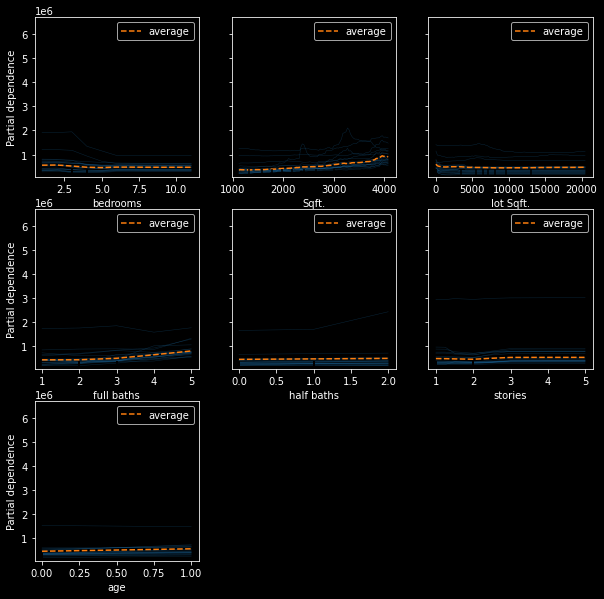

In [53]:
features = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']
PartialDependenceDisplay.from_estimator(xg_best_scaled, X_train, features=features, feature_names=features, kind='both', subsample=20)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [54]:
# svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# svr_lin = SVR(kernel="linear", C=100, gamma="auto")
# svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

# evalModel(X_train_prep_dropfirst, y_train, svr_rbf, 5)
# evalModel(X_train_prep_dropfirst, y_train, svr_lin, 5)
# evalModel(X_train_prep_dropfirst, y_train, svr_poly, 5)

In [55]:
# svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# svr_lin = SVR(kernel="linear", C=100, gamma="auto")
# svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

# evalModel(X_train_prep, y_train, svr_rbf, 5)
# evalModel(X_train_prep, y_train, svr_lin, 5)
# evalModel(X_train_prep, y_train, svr_poly, 5)